In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np
import collections
import re
import random
import math

In [2]:
# 带蒙版的softmax操作
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = utils.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
x = torch.rand(2, 2, 4)

In [4]:
masked_softmax(x, torch.tensor([2, 3]))

tensor([[[0.5466, 0.4534, 0.0000, 0.0000],
         [0.6793, 0.3207, 0.0000, 0.0000]],

        [[0.2233, 0.2385, 0.5381, 0.0000],
         [0.4040, 0.3137, 0.2823, 0.0000]]])

In [5]:
masked_softmax(x, torch.tensor([[2, 2], [3, 3]]))

tensor([[[0.5466, 0.4534, 0.0000, 0.0000],
         [0.6793, 0.3207, 0.0000, 0.0000]],

        [[0.2233, 0.2385, 0.5381, 0.0000],
         [0.4040, 0.3137, 0.2823, 0.0000]]])

In [6]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2698, 0.2887, 0.4415, 0.0000]],

        [[0.4371, 0.5629, 0.0000, 0.0000],
         [0.3227, 0.2302, 0.2271, 0.2200]]])

# 加性注意力

In [7]:
# 由于key/value/query的shape可能不一样，可以增加权重将其统一维度
# a(q, k) = W_v.T * tanh(W_q * q + W_k * k), a(q, k)每一个值为标量
# W_v shape:(h,), W_q shape(h, q), W_k shape(h, k), 将维度统一到h维

In [8]:
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        print(f'[params] queries shape: {queries.shape}, keys shape: {keys.shape}, values shape: {values.shape}')
        # forward其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小）
        queries, keys = self.W_q(queries), self.W_k(keys)
        print(f'[params * W] queries shape: {queries.shape}, keys shape: {keys.shape}, values shape: {values.shape}')
        # queries形状：(batch_size，queries步数或词元序列长度_查询的个数，num_hidden)
        # keys：(batch_size，keys步数或词元序列长度_“键－值”对的个数，num_hidden)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和后，形状：(batch_size，查询的个数，“键－值”对的个数，num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        print(f'[q k dim cat] features shape: {features.shape}')
        # tanh 激活放缩数值，不影响形状
        features = torch.tanh(features)
        print(f'[tanh] features shape: {features.shape}')
        # scores操作逻辑理解意义，scores操作前，batch_size单独看，每批是 (查询的个数, “键-值”对的个数, num_hiddens), 
        # 即每个 查询和键 由num_hiddens个元素表示，w_v形状为(num_hiddens, 1), 
        # scores操作 features * w_v 相当于将每个 查询和键 由num_hiddens个元素变为1个元素表示，
        # 所以scores后的形状：(batch_size，查询的个数，“键-值”对的个数, 1)，self.w_v后仅有一个输出，因此从形状中移除最后那个维度。
        # scores形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        print(f'[features * W] scores shape: {scores.shape}')
        # masked_softmax 只改数值，将有效长度外的权重降到0，不影响形状
        self.attention_weights = masked_softmax(scores, valid_lens)
        print(f'[masked_softmax scores] attention_weights shape: {self.attention_weights.shape}')
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        # 输出形状（批量大小，查询的步数，值的维度）
        result = torch.bmm(self.dropout(self.attention_weights), values)
        print(f'[bmm attention_weights values] result shape: {result.shape}')
        return result

In [9]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

[params] queries shape: torch.Size([2, 1, 20]), keys shape: torch.Size([2, 10, 2]), values shape: torch.Size([2, 10, 4])
[params * W] queries shape: torch.Size([2, 1, 8]), keys shape: torch.Size([2, 10, 8]), values shape: torch.Size([2, 10, 4])
[q k dim cat] features shape: torch.Size([2, 1, 10, 8])
[tanh] features shape: torch.Size([2, 1, 10, 8])
[features * W] scores shape: torch.Size([2, 1, 10])
[masked_softmax scores] attention_weights shape: torch.Size([2, 1, 10])
[bmm attention_weights values] result shape: torch.Size([2, 1, 4])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

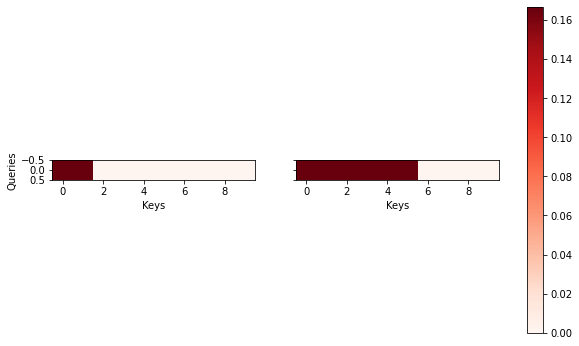

In [12]:
# 2个batch, 每个都是1个query对应10个keys，查看query和key的对应注意力评分
utils.show_heatmaps(attention.attention_weights.reshape((1, 2, 1, 10)), xlabel='Keys', ylabel='Queries', figsize=(10, 10), shrink=0.6)

# 缩放点积注意力

In [13]:
# 使用点积可以得到计算效率更高的评分函数， 但是点积操作要求查询和键具有相同的长度

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        # scores 形状：(batch_size，查询的个数，“键－值”对的个数)
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [14]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

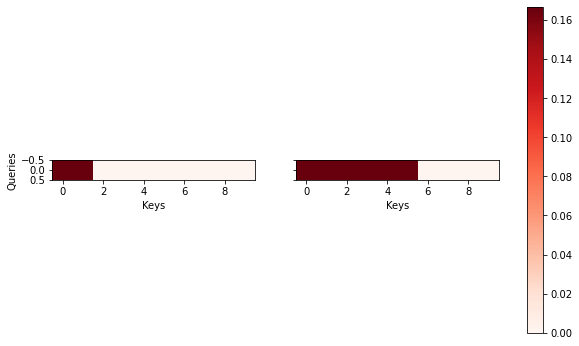

In [15]:
utils.show_heatmaps(attention.attention_weights.reshape((1, 2, 1, 10)), xlabel='Keys', ylabel='Queries', figsize=(10, 10), shrink=0.6)